<a href="https://colab.research.google.com/github/sayanbanerjee32/NLP-with-fastai2.0/blob/main/fastai_on_20newsgroup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install fastai 2 version

uncomment if required

In [1]:
#!pip install fastai --upgrade

# Data
Import data

In [2]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

In [3]:
def twenty_newsgroup_to_df(data_set = 'train'):
    newsgroups_train = fetch_20newsgroups(subset=data_set, 
                                          remove=('headers', 'footers',
                                                  'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame(newsgroups_train.target_names)
    targets.columns = ['title']

    train = pd.merge(df, targets, left_on='target', right_index=True)
    #out['date'] = pd.to_datetime('now')
    #out.to_csv('20_newsgroup.csv')
    return train


train_data_df = twenty_newsgroup_to_df('train')
test_data_df = twenty_newsgroup_to_df('test')

In [4]:
train_data_df.info(),test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11314 entries, 0 to 11302
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11314 non-null  object
 1   target  11314 non-null  object
 2   title   11314 non-null  object
dtypes: object(3)
memory usage: 353.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7532 entries, 0 to 7519
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7532 non-null   object
 1   target  7532 non-null   object
 2   title   7532 non-null   object
dtypes: object(3)
memory usage: 235.4+ KB


(None, None)

Number of classes in train and test

In [5]:
len(train_data_df.target.unique()),len(train_data_df.title.unique())

(20, 20)

In [6]:
len(test_data_df.target.unique()),len(test_data_df.title.unique())

(20, 20)

# Initial model using transfer learning

In [7]:
from fastai.text.all import *

## create data loader from data frame

Defining a seed for reproducible results

In [16]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [17]:
random_seed(1, True)
dls = TextDataLoaders.from_df(train_data_df, text_col='text', label_col='title')
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj due to the resolution and size it is in 14 parts . \n\n xxmaj this is a uuencoded bitmap . xxunk 256 colors . \n xxmaj the picture is a xxunk xxunk on a desert with blue sky background . \n xxmaj the size is just right for centered wallpaper on a 1024x768 display \n because it leaves a border at the bottom just big enough for icons \n to fit in without being on top of the picture . xxmaj xxunk image \n quality and resolution - i have not seen much better . \n\n xxmaj for those of you who have n't worked with xxunk image files , here \n is how to put it back together . \n\t 1 . save the 14 parts to 14 individual files \n\t 2 . use a text editor to remove the header and xxunk \n\t▁ in each file",comp.os.ms-windows.misc
1,"xxbos xxrep 10 - cut here xxrep 10 - part 02 / 03 \n xxup xxunk k / xxup xxunk ) xxunk \n xxup xxunk # xxunk [ ) ' xxunk / $ xxunk ? ' # xxup xxunk / h # xxup c ' ! \ xxunk \n xxup xxunk = xxunk _ . * xxup xxunk > o \ xxunk \n xxup xxunk ; \ xxunk \ < xxunk , z = k ( / xxup sn = q \n xxup xxunk ' \ > xxunk _ ' / xxup xxunk = xxunk < xxunk > i \n xxup xxunk \ xxunk "" ' # xxunk \n xxup xxunk / xxunk : p$ / 1q < xxunk / % xxunk / % h < xxunk \n xxup xxunk , xxunk "" / xxup xxunk xxup xxunk : ul xxunk > cv , pj 4 \n xxup xxunk \",comp.sys.ibm.pc.hardware
2,"xxbos xxmaj archive - name : graphics / resources - list / part1 \n xxmaj last - modified : 1993 / 04 / 17 \n\n\n xxmaj computer xxmaj graphics xxmaj resource xxmaj listing : xxup weekly xxup posting [ xxup part 1 / 3 ] \n▁ xxrep 51 = \n xxmaj last xxmaj change : 17 xxmaj april 1993 \n\n xxmaj many faqs , including this xxmaj listing , are available on the archive site \n pit-manager.mit.edu ( alias rtfm.mit.edu ) [ 18.172.1.27 ] in the directory \n pub / usenet / news.answers . xxmaj the name under which a xxup faq is archived appears \n in the xxmaj archive - name line at the top of the article . \n xxmaj this xxup faq is archived as graphics / resources - list / part[1 - 3 ] \n\n xxmaj there 's a mail server on that machine . xxmaj",sci.crypt


## create text learner

use F1 score as metrics and find optimum learning rate

SuggestedLRs(lr_min=1.0964782268274575e-05, lr_steep=9.120108734350652e-05)

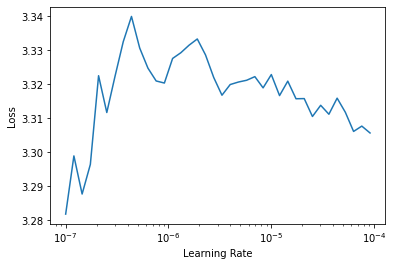

In [18]:
#dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
fscore = F1Score(average='weighted')
ls_fucn = CrossEntropyLossFlat()
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, 
                                loss_func = ls_fucn,
                                metrics=[accuracy,fscore])
#learn.fine_tune(2, 1e-2)
learn.lr_find()

Tune the model with suggested learning rate that is min learning rate devided by 10.

In [20]:
learn.fit_one_cycle(1, 0.01) # min / 10

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,nan,3.060148,0.047303,0.042331,01:07


In [ ]:
learn.fine_tune(5,0.01)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,nan,3.060204,0.049514,0.043058,01:07


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,nan,3.030513,0.052166,0.044313,02:09


## Predict on test data

In [ ]:
predict_df = test_data_df.text.apply(learn.predict)
#predict_df.head()
predict_df_class = [x[0] for x in predict_df.values]
predict_df_prob = [max(x[2].tolist()) for x in predict_df.values]
print(predict_df_class[:10])
print(predict_df_prob[:10])

## Classification report

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
act_class = [str(c) for c in test_data_df.title.values]
len(np.unique(act_class))

In [ ]:
print(classification_report(act_class, predict_df_class))